# Loan Prediction Project

In [190]:
# load the libraries Command '%pylab inline' can make a few useful libraries already imported and plot data inline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

# 1. Basic Data Analysis 

Load data 

In [191]:
df = pd.read_csv('./train.csv') # reading the training dataset in a dataframe using Pandas
df.shape # print the size of the dataset
         # we could see from below, there are 614 rows and 13 columns 

(614, 13)

In [192]:
df.head() # print the first five rows of dataset

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [193]:
df.describe() # summary of the statistics of the dataset
              # we could see from below: 
              # LoanAmount has (614-592)=22, Loan_Amount_Term has (614 - 600) = 14
              # Credit_History has (614 - 564) = 50 missing items
              # About 84% people has Credit_History as shown by the mean of Credit_History 

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [194]:
df['Property_Area'].value_counts() # For the non-numerical values
                                   # we could print out the frequency table to see whether it makes sense

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

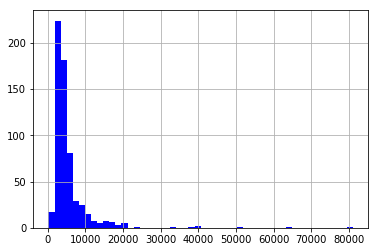

In [195]:
df['ApplicantIncome'].hist(bins=50, color='blue') # For the numerical values
                                                  # we could print out the histogram

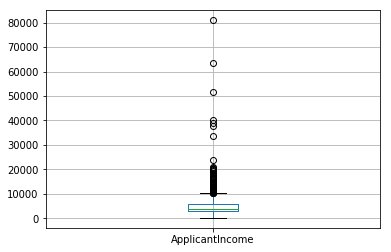

In [196]:
df.boxplot(column='ApplicantIncome') # We could also look at the boxplot
                                     # The boxplot confirms that there are many outliers/extreme values as we see above

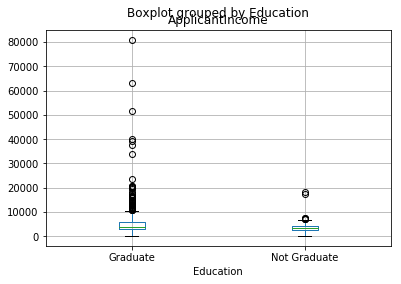

In [197]:
df.boxplot(column='ApplicantIncome', by='Education') # Segregate them by Education
                                                     # We could see there is no substantial difference 
                                                     # between the mean income of graduate and non-graduates 

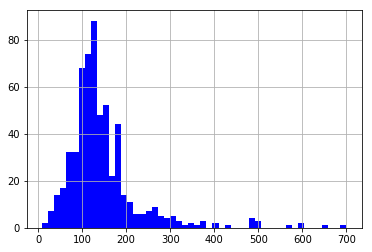

In [198]:
df['LoanAmount'].hist(bins=50, color='blue') # Now let's look at the histogram of LoanAmount

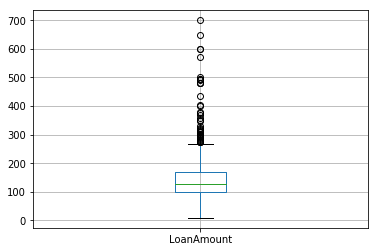

In [199]:
df.boxplot(column='LoanAmount') # We could look at the boxplot 
                                # Again, there are some extreme values 
                                # Clearly, both ApplicantIncome and LoanAmount require some amount of data munging

# Now let's understand the category variables in more details

In [200]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print('Frequency Table for Credit History:')
print(temp1)

print('\nProbability of getting loan for each Credit History class:') 
print(temp2)

Frequency Table for Credit History:
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probability of getting loan for each Credit History class:
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


Now we see that for people without Credit_History, the probability of getting loan is 7.8%, quite low. <br>For people with Credit_History, the probability is 80%, quite high. <br> We can plot them out in bar plots as follow. 

Text(0.5,1,'Probability of getting loan by credit history')

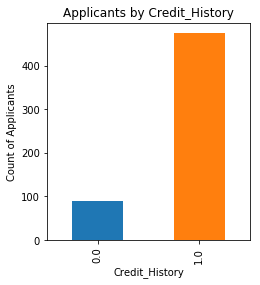

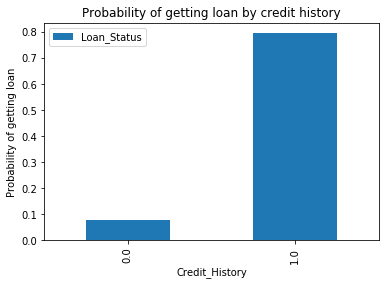

In [201]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt 
%matplotlib inline
f = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
temp1.plot(kind='bar')
plt.title("Applicants by Credit_History")
plt.xlabel('Credit_History')
plt.ylabel('Count of Applicants')

temp2.plot(kind='bar')
plt.xlabel('Credit_History')
plt.ylabel('Probability of getting loan')
plt.title("Probability of getting loan by credit history")

This shows that the chance of getting a loan is eight-fold if the applicant has a valid credit history.<br> These two plots could also be visualized in a stacked chart. 

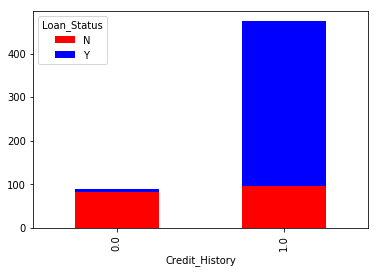

In [202]:
temp3 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

# 2. Data Munging in Python using Pandas

From our previous analysis, we found two problems in the data: <br> 1. There are missing values in some variables. We should estimate those values wisely depending on the amount of missing values and the expected importance of variables. <br> 2. While looking at the distributions, we saw that ApplicantIncome and LoanAmount seemed to contain extreme values at either end. <br> In addition to these problems with numerical fields, we should also look at the non-numerical fields i.e. Gender, Property_Area, Married, Education and Dependents to see, if they contain any useful information.

# Check missing values in the dataset
Let's look at how many missing values are in each column 

In [203]:
df.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Fill the missing values <br> For continuous and numerical variables, we fill the missing value with their mean <br> for categorial variables, we fill the missing value with the most frequent case, for example, "Gender" with "Male" occurs more, we fill the missing value for "Gender" with "Male". 

In [204]:
# check the most frequent occurence for categorial variables
#df['Gender'].value_counts()
#df['Married'].value_counts()
df['Self_Employed'].value_counts()
#df['Dependents'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [205]:
# df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
df['Self_Employed'].fillna('No',inplace=True)

Now, we will create a Pivot table, which provides us median values for all the groups of unique values of Self_Employed and Education features. Next, we define a function, which returns the values of these cells and apply it to fill the missing values of loan amount. <br> Remember to comment out the previous line that fill with mean value and rerun the data 

In [206]:
table = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
     return table.loc[x['Self_Employed'],x['Education']]
# Replace missing values
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

# How to treat for extreme values in distribution of LoanAmount and ApplicantIncome?

Let’s analyze LoanAmount first. Since the extreme values are practically possible, i.e. some people might apply for high value loans due to specific needs. So instead of treating them as outliers, let’s try a log transformation to nullify their effect.

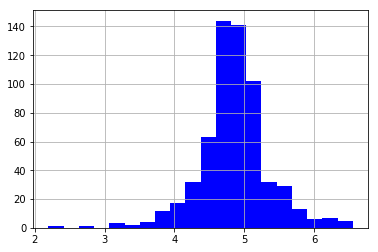

In [207]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20, color='blue')

Now the distribution looks much closer to normal and effect of extreme values has been significantly subsided.

Coming to ApplicantIncome. One intuition can be that some applicants have lower income but strong support Co-applicants. So it might be a good idea to combine both incomes as total income and take a log transformation of the same.

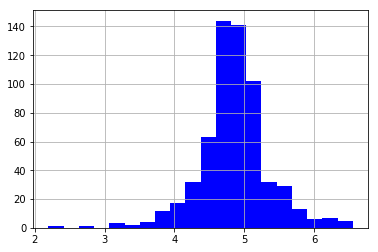

In [208]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['LoanAmount_log'].hist(bins=20, color='blue') 

Now we see that the distribution is much better than before.

# 3. Building a Predictive Model 

Let's now look at the python code to create a predictive model on our data set.
Skicit-Learn (sklearn) is the most commonly used library in Python for this purpose.Since, sklearn requires all inputs to be numeric, we should convert all our categorical variables into numeric by encoding the categories. This can be done using the following code:

In [209]:
df['Credit_History'].fillna('1.0', inplace=True)

In [210]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(list(df[i]))
df.dtypes 

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History        object
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

Now we will define a generic function for model prediction, accuracy and cross validation.

In [211]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
    #Fit the model:
    model.fit(data[predictors],data[outcome])  
    #Make predictions on training set:
    predictions = model.predict(data[predictors])
  
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))

    #Perform k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:
        # Filter training data
        train_predictors = (data[predictors].iloc[train,:])
    
        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]
    
        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)
    
        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
    
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    #Fit the model again so that it can be refered outside the function:
    model.fit(data[predictors],data[outcome]) 

# Logistics Regression
Let’s make our first Logistic Regression model. One way would be to take all the variables into the model but this might result in overfitting (don’t worry if you’re unaware of this terminology yet). In simple words, taking all variables might result in the model understanding complex relations specific to the data and will not generalize well. Read more about Logistic Regression.

We can easily make some intuitive hypothesis to set the ball rolling. The chances of getting a loan will be higher for:

<br> Applicants having a credit history (remember we observed this in exploration?)
<br> Applicants with higher applicant and co-applicant incomes
<br> Applicants with higher education level
<br> Properties in urban areas with high growth perspectives
<br> So let’s make our first model with ‘Credit_History’.

In [212]:
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, df, predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


In [213]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


# Decision Tree

In [214]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Gender','Married','Education']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.946%


In [220]:
#We can try different combination of variables:
df['Loan_Amount_Term'].fillna('360.0', inplace=True) # deal with missing values
predictor_var = ['Credit_History','Loan_Amount_Term','LoanAmount_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 88.925%
Cross-Validation Score : 69.374%


# Random Forest

In [221]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 77.526%


Here we see that the accuracy is 100% for the training set. This is the ultimate case of overfitting and can be resolved in two ways:

<br> Reducing the number of predictors
<br> Tuning the model parameters
<br> Let’s try both of these. First we see the feature importance matrix from which we’ll take the most important features.


In [223]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(featimp)

Credit_History      0.269269
TotalIncome_log     0.262832
LoanAmount_log      0.220429
Dependents          0.057052
Property_Area       0.049007
Loan_Amount_Term    0.040338
Gender              0.027970
Married             0.025924
Education           0.025614
Self_Employed       0.021564
dtype: float64


Let’s use the top 5 variables for creating a model. Also, we will modify the parameters of random forest model a little bit.

In [229]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['TotalIncome_log','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model, df, predictor_var,outcome_var)

Accuracy : 82.573%
Cross-Validation Score : 80.299%


Notice that although accuracy reduced, but the cross-validation score is improving showing that the model is generalizing well.